* XGBoost 버전 확인

In [4]:
#conda install -c anaconda py-xgboost -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.11.0
  latest version: 4.12.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /Users/cwj/miniconda3/envs/tf25

  added / updated specs:
    - py-xgboost


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.4.26  |       hca03da5_0         127 KB  anaconda
    certifi-2021.10.8          |   py38hca03da5_2         146 KB  anaconda
    openssl-1.1.1n             |       h1a28f6b_0         3.3 MB  anaconda
    py-xgboost-1.5.0           |   py38hca03da5_1         153 KB  anaconda
    ------------------------------------------------------------
                                           Total:         3.7 MB

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-202

In [35]:
import xgboost
print(xgboost.__version__)

1.5.0


### 위스콘신 Breast Cancer 데이터 셋

**데이터 세트 로딩 하기**

In [58]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
cancer_df['target']= dataset.target
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


### 파이썬 Native XGBoost 적용

In [59]:
# xgboost 패키지 로딩하기
import xgboost as xgb # python wrapper - xgboost
from xgboost import plot_importance

#### 데이터 확인 및 train_test_split

In [60]:
# 0: malignant(악성 종양), 1: benign(양성 종양)
print(dataset.target_names)
cancer_df['target'].value_counts().to_frame()

['malignant' 'benign']


,target
1,357
0,212


In [55]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label이므로 Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 컬럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출 -> 즉, 학습/테스트 쪼개기
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습, 10%는 검증 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train, test_size=0.1, random_state=156)

print(f"{X_train.shape, y_train.shape}이 아래와 같이 쪼개짐")
print(X_tr.shape, X_val.shape, y_tr.shape, y_val.shape)

((455, 30), (455,))이 아래와 같이 쪼개짐
(409, 30) (46, 30) (409,) (46,)


In [ ]:
#### 

#### XGBoost를 위한 DMatrix 변환
**학습과 검증, 예측 데이터 세트를 DMatrix로 변환**
* DMatrix는 넘파이 array, DataFrame에서도 변환 가능

In [57]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환. 
# 학습, 검증, 테스트용 DMatrix를 생성.
# 아래 X_tr, X_val, X_test는 모두 데이터프레임, y_tr, y_val, y_test는 모두 시리즈
dtr = xgb.DMatrix(data=X_tr, label=y_tr) # 학습 데이터/타겟 -> DMatrix
dval = xgb.DMatrix(data=X_val, label=y_val) # 검증 데이터/타겟 -> DMatrix
dtest = xgb.DMatrix(data=X_test, label=y_test) # 테스트 데이터/타겟 -> DMatrix

#### 하이퍼 파라미터, early stopping 설정

**하이퍼 파라미터 설정**

In [62]:
# xgboost의 하이퍼 파라미터 설정 
params = {
    'max_depth': 3, # DecisionTree기반 이기 때문에 max_depth 설정
    'eta': 0.05, # learning rate
    'objective':'binary:logistic', # “binary:logistic“: XGBoost loss function for binary classification.
    'eval_metric':'logloss', # 학습할 때, 검증데이터 기반으로 log(loss)를 구한다.
}
num_rounds = 400 # Number of Boosting Iteration (학습 반복횟수)

#### xgb.train()

**주어진 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달하고 학습**

In [64]:
# 학습 데이터 셋은 'train', 평가 데이터셋은 'eval'로 명기합니다.
eval_list = [(dval,'eval')] # 또는 eval_list = [(dtr,'train'),(dval,'eval')] 로 작성해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 trian( ) 함수의 파라미터로 전달
# dtrain (DMatrix) :  Data to be trained.
# num_boost_round(int):  Number of boosting iterations.
# early_stopping_rounds(int) : Validation metric needs to improve at least once in every early_stopping_rounds round(s) to continue training.
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round=num_rounds, \
                     early_stopping_rounds=50, evals=eval_list) # 아래에서 176번까지 했다 -> 126번째의 eval-logloss이후에 이것보다 작은값이 50번에 걸쳐 나오지 않았다.

[0]	eval-logloss:0.66183
[1]	eval-logloss:0.63609
[2]	eval-logloss:0.61144
[3]	eval-logloss:0.59204
[4]	eval-logloss:0.57329
[5]	eval-logloss:0.55037
[6]	eval-logloss:0.52929
[7]	eval-logloss:0.51534
[8]	eval-logloss:0.49718
[9]	eval-logloss:0.48154
[10]	eval-logloss:0.46990
[11]	eval-logloss:0.45474
[12]	eval-logloss:0.44229
[13]	eval-logloss:0.42961
[14]	eval-logloss:0.42065
[15]	eval-logloss:0.40958
[16]	eval-logloss:0.39887
[17]	eval-logloss:0.39050
[18]	eval-logloss:0.38254
[19]	eval-logloss:0.37393
[20]	eval-logloss:0.36789
[21]	eval-logloss:0.36017
[22]	eval-logloss:0.35421
[23]	eval-logloss:0.34683
[24]	eval-logloss:0.34111
[25]	eval-logloss:0.33634
[26]	eval-logloss:0.33082
[27]	eval-logloss:0.32675
[28]	eval-logloss:0.32099
[29]	eval-logloss:0.31671
[30]	eval-logloss:0.31277
[31]	eval-logloss:0.30882
[32]	eval-logloss:0.30437
[33]	eval-logloss:0.30103
[34]	eval-logloss:0.29794
[35]	eval-logloss:0.29499
[36]	eval-logloss:0.29295
[37]	eval-logloss:0.29043
[38]	eval-logloss:0.28

#### xgb.predict( )

**predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환**

In [67]:
# xgb.predict()하면 결과가 1일 확률값의 리스트가 반환된다.
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(f"pred_probs : {np.round(pred_probs[:10],3)}")

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('preds(예측값) 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
pred_probs : [0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
preds(예측값) 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [24]:
dtest.num_row(), pred_probs.shape

(114, (114,))

#### 예측평가

**get_clf_eval( )을 통해 예측 평가**

In [68]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [69]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


#### **Feature Importance 시각화**

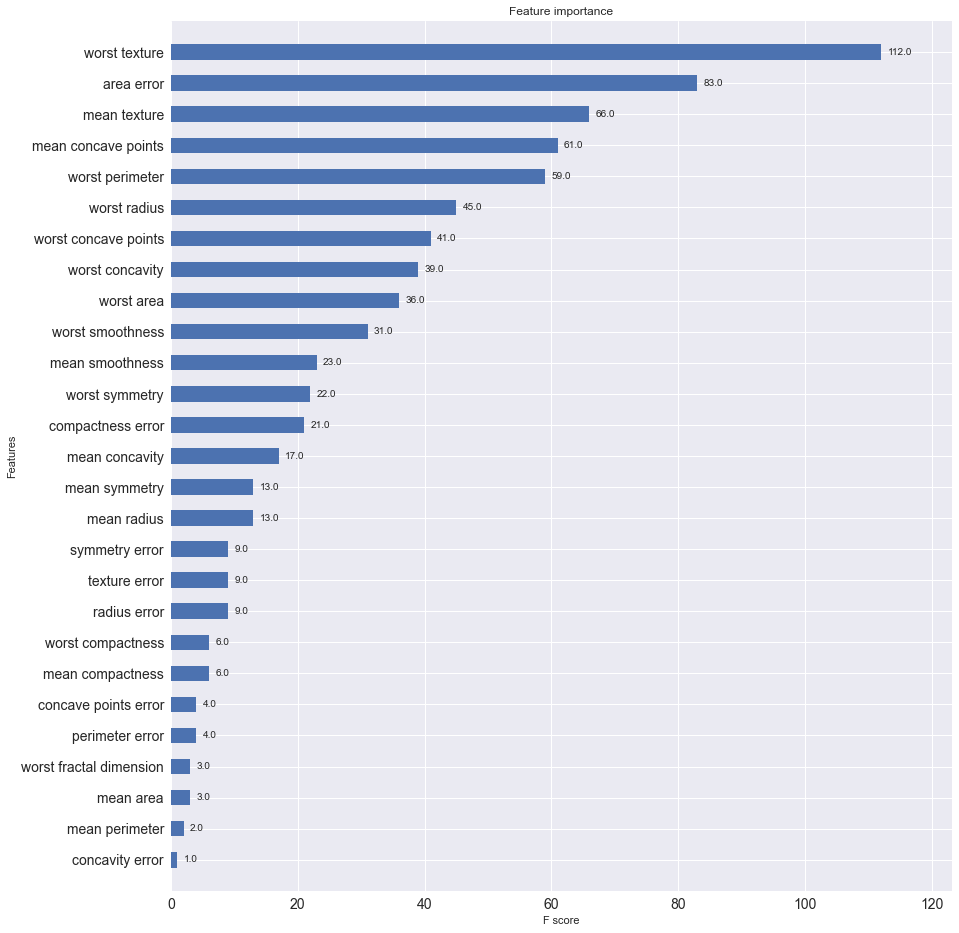

In [91]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('seaborn') # 그래프 스타일
fig, ax = plt.subplots(figsize=(14, 16)) # ax가 그림그리는 부분이다.
ax.tick_params(labelsize=14)
plot_importance(xgb_model, ax=ax, height=0.5)
plt.show()

### 사이킷런 Wrapper XGBoost 개요 및 적용 

#### **사이킷런 래퍼 클래스 임포트, 학습 및 예측**<br>
-> 앞(파이썬 래퍼)과 다르게 DMatrix 쓸 필요없음

In [92]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

In [96]:
# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 미입력해도 수행에 문제 없음.
# n_estimators(int) :  Number of boosting rounds
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=1)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1] # [:,1]해서 1일떄의 확률값만 저장

In [97]:
# 데이터가 작기 떄문에 위에서 얼리스타핑한게 성능이 더 안좋게 나오고, 지금한게 성능이 더 좋게 나옴
# 일반적으론 얼리스타핑한 것의 성능이 더 좋다. 여기서 반대로 나온 이유는 데이터 크기가 작아서
get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


#### **early stopping을 50으로 설정하고 재 학습/예측/평가**

In [98]:
from xgboost import XGBClassifier

In [102]:
# eval_set :  A list of (X, y) tuple pairs to use as validation sets
# eval_metric :  If a str, should be a built-in evaluation metric to use
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr,y_tr), (X_val, y_val)] # 검증 데이터셋
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss",
               eval_set=evals, verbose=1) #위와 마찬가지로 0~176번까지만 학습

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

[130]	validation_0-logloss:0.01886	validation_1-logloss:0.25712
[131]	validation_0-logloss:0.01863	validation_1-logloss:0.25609
[132]	validation_0-logloss:0.01839	validation_1-logloss:0.25649
[133]	validation_0-logloss:0.01816	validation_1-logloss:0.25789
[134]	validation_0-logloss:0.01802	validation_1-logloss:0.25811
[135]	validation_0-logloss:0.01785	validation_1-logloss:0.25794
[136]	validation_0-logloss:0.01763	validation_1-logloss:0.25876
[137]	validation_0-logloss:0.01748	validation_1-logloss:0.25884
[138]	validation_0-logloss:0.01732	validation_1-logloss:0.25867
[139]	validation_0-logloss:0.01719	validation_1-logloss:0.25876
[140]	validation_0-logloss:0.01696	validation_1-logloss:0.25987
[141]	validation_0-logloss:0.01681	validation_1-logloss:0.25960
[142]	validation_0-logloss:0.01669	validation_1-logloss:0.25982
[143]	validation_0-logloss:0.01656	validation_1-logloss:0.25992
[144]	validation_0-logloss:0.01638	validation_1-logloss:0.26035
[145]	validation_0-logloss:0.01623	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=10,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [104]:
ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1] # 1일 때의 확률만

get_clf_eval(y_test , ws50_preds, ws50_pred_proba)
## python wrapper와 성능이 정확히 일치

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9933


#### early stopping을 너무 작게하면 성능이 떨어질수있다.
**early stopping을 10으로 설정하고 재 학습/예측/평가**

In [33]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

#### 사이킷런 래퍼 클래스 -> Feature Importance 시각화

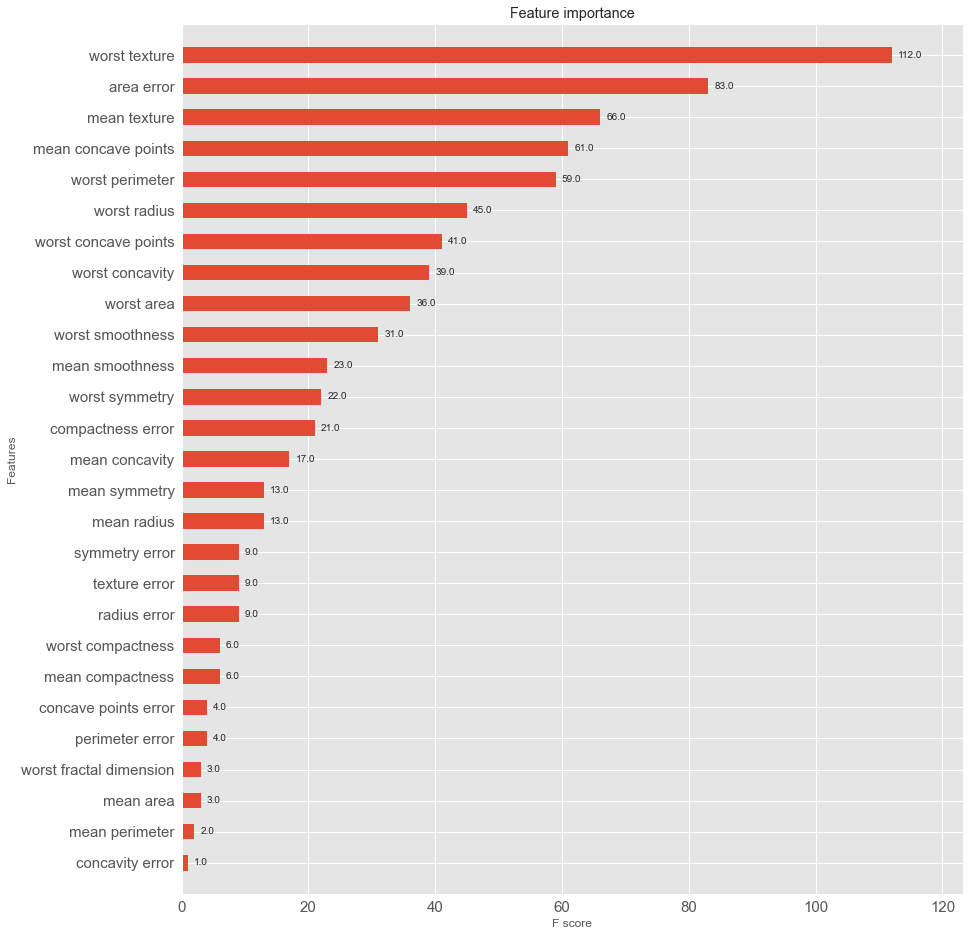

In [106]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(14, 16)) # 그림그리는건 ax가 담당한다.
ax.tick_params(labelsize=15)
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax,height=0.5)
plt.show()